In [2]:
pip install gensim


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
import pickle

In [31]:
df = pd.read_csv('processced text.csv')


### Preprocessing the text for calculating Coherence score

In [32]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: x.split())
texts = df['preprocessed_text'].tolist()
# create a gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)


### Model

In [4]:
#get matrix to train model
bow_matrix = sparse.load_npz("bow_matrix.npz")

In [8]:
#get feature names

with open('out/count_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
    
feature_names = vectorizer.get_feature_names_out()

/home/qianfu/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.1.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 10 Topics Model

In [5]:
#set up model with 10 topics
num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=50, random_state=42)

In [6]:
#fit model
lda_model.fit(bow_matrix)

LatentDirichletAllocation(max_iter=50, random_state=42)

In [9]:
#print out top 50 words in 10 topics 
num_top_words = 50

topic_words = []
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(", ".join(top_words))
    topic_words.append(top_words)

Topic 1:
new, york, city, year, nyc, mayor, ny, child, jersey, theater, brooklyn, restaurant, manhattan, island, state, connecticut, food, long, number, street, bronx, michael, day, play, school, open, week, blasio, lottery, bloomberg, say, art, square, guide, mental, family, come, public, event, citys, parent, center, look, cultural, times, east, disorder, old, childhood, yearold
Topic 2:
new, city, york, coronavirus, year, real, state, estate, home, housing, travel, ny, ncov, park, space, area, building, safety, hurricane, residential, gas, water, change, oil, andrew, global, cuomo, energy, center, climate, pandemic, long, work, hotel, say, time, traffic, india, manhattan, national, week, vacation, accident, storm, service, million, leave, warming, road, administration
Topic 3:
united, states, trump, government, president, politic, election, party, donald, state, washington, house, republican, obama, international, say, presidential, ukraine, democratic, senate, biden, military, russ

In [10]:
#The coherence score of the model with 10 topic
id2word = {i: token for i, token in enumerate(feature_names)}

num_top_words = 50
topics = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
    topic_words2 = [feature_names[i] for i in top_features_ind]
    topics.append(topic_words2)
    

# compute Coherence Score 
coherence_model_lda = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score (C_v): ', coherence_lda)

Coherence Score (C_v):  0.4954461521325218


# Assessing how similar (or dissimilar each topic is)

In [11]:
bow = vectorizer.transform([' '.join(words) for words in topic_words])

In [14]:
similarity_matrix = []

for topic_1 in bow:
    for topic_2 in bow:
        similarity_matrix.append(cosine_similarity(topic_1, topic_2)[0][0])

similarity_matrix = np.matrix(similarity_matrix).reshape(10, 10)


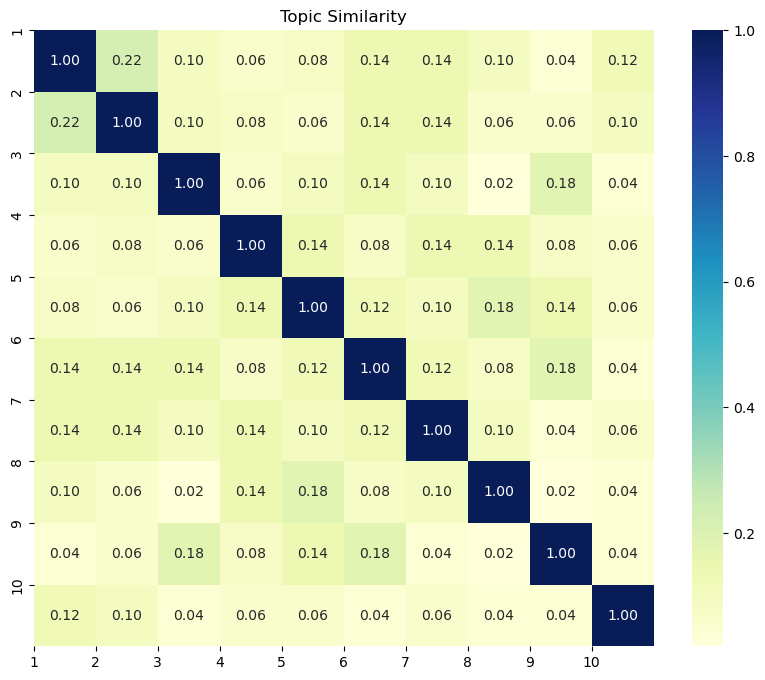

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# plt.imshow(, cmap='YlGnBu', interpolation='nearest')
sns.heatmap(similarity_matrix.reshape((10, 10)), annot=True, cmap="YlGnBu", fmt=".2f")

plt.xticks(np.arange(10), np.arange(1, 11))
plt.yticks(np.arange(10), np.arange(1, 11))

plt.title("Topic Similarity")
plt.show()


### Visualizing the distribution of articles across the 10 topics

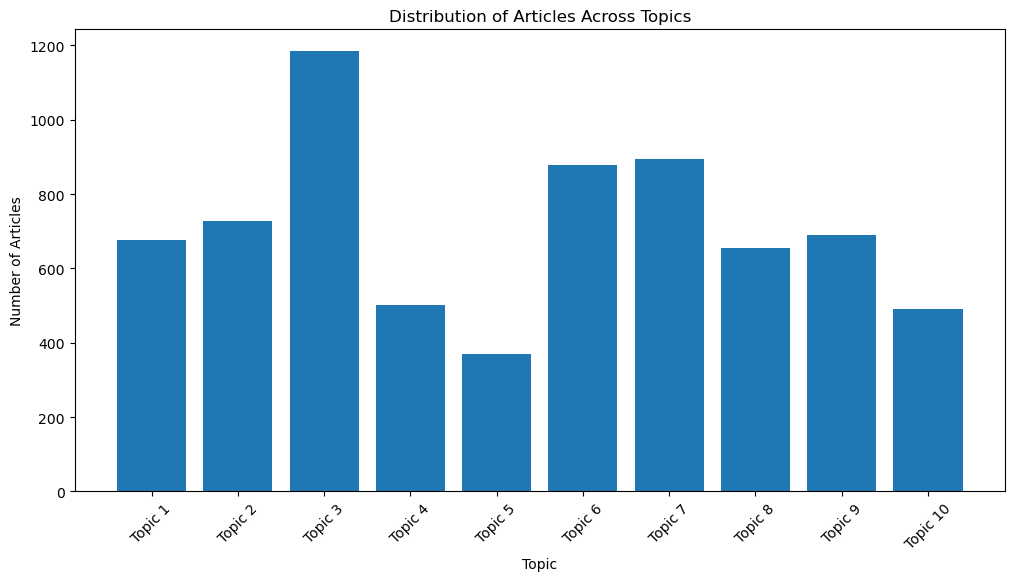

In [14]:

# get document-topic distribution
doc_topic_dist = lda_model.transform(bow_matrix)

# counts how many documents have their highest probability in each topic
topic_counts = np.argmax(doc_topic_dist, axis=1)
topic_counts = np.bincount(topic_counts, minlength=lda_model.n_components)

# Step 3: Visualize the Distribution
plt.figure(figsize=(12, 6))
plt.bar(range(lda_model.n_components), topic_counts, tick_label=['Topic {}'.format(i+1) for i in range(lda_model.n_components)])
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles Across Topics')
plt.xticks(rotation=45)
plt.show()


### Hyperparameter Tuning

In [17]:

#from sklearn.model_selection import GridSearchCV

# Define Search Param
#search_params = {
  #'learning_decay': [.5, .7, .9],
  #'doc_topic_prior': [0.5, 0.7, 0.9, 'auto'], # alpha
 # 'topic_word_prior': [0.5, 0.7, 0.9, 'auto'] # beta
#}

# Init the Model
#lda = LatentDirichletAllocation(learning_method='batch', max_iter=10, random_state=42)

# Init Grid Search Class
#model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search

#model.fit(bow_matrix)

# Best Model
#best_lda_model = model.best_estimator_

# Get the alpha and beta parameters
#best_alpha = best_lda_model.doc_topic_prior
#best_beta = best_lda_model.topic_word_prior

#print("Best alpha (doc_topic_prior):", best_alpha)
#print("Best beta (topic_word_prior):", best_beta)


/home/qianfu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
105 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/qianfu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/home/qianfu/.local/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/qianfu/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/qianfu/.local/lib/py

Best alpha (doc_topic_prior): 0.5
Best beta (topic_word_prior): 0.5


### 5 topic model

In [16]:
lda_model_five = LatentDirichletAllocation(n_components=5, max_iter=50,
                                      random_state=42)

In [17]:
lda_model_five.fit(bow_matrix)

LatentDirichletAllocation(max_iter=50, n_components=5, random_state=42)

In [18]:
#top 50 words in each topic
num_top_words = 50

topic_five = []
for topic_idx, topic in enumerate(lda_model_five.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(", ".join(top_words))
    topic_five.append(top_words)

Topic 1:
book, new, day, movie, life, year, television, tv, like, make, time, program, child, literature, woman, good, people, theater, family, story, art, food, know, week, say, work, night, film, live, come, play, quotation, long, man, restaurant, writer, love, way, write, look, black, world, type, young, content, home, late, die, music, fashion
Topic 2:
new, york, city, year, coronavirus, company, say, puzzle, school, state, time, mayor, world, make, home, job, million, ny, real, week, day, ncov, industry, public, safety, plan, computer, estate, education, service, park, bee, federal, people, work, report, nyc, rate, crossword, housing, change, internet, bank, area, big, help, market, business, executive, long
Topic 3:
united, states, government, trump, politic, president, election, party, say, state, donald, washington, house, international, obama, military, force, republican, defense, american, war, federal, presidential, ukraine, law, democratic, right, biden, senate, court, immi

In [20]:
#The coherence score of model with 5 topics 
id2word = {i: token for i, token in enumerate(feature_names)}

num_top_words = 50
topics_five = []
for topic_idx, topic in enumerate(lda_model_five.components_):
    top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
    topic_words2 = [feature_names[i] for i in top_features_ind]
    topics_five.append(topic_words2)
    

# compute Coherence Score 
coherence_model_lda = CoherenceModel(topics=topics_five, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score (C_v): ', coherence_lda)

Coherence Score (C_v):  0.46452518245052266


In [24]:
#lda_model_tun.fit(bow_matrix)

LatentDirichletAllocation(doc_topic_prior=0.5, max_iter=100, n_components=5,
                          random_state=42, topic_word_prior=0.5)

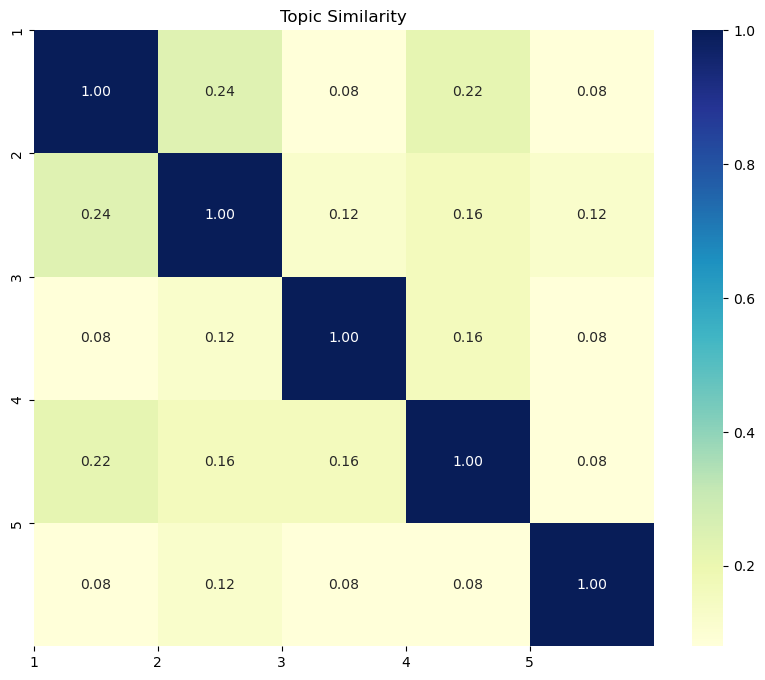

In [21]:
#create similarity heatmap
bow = vectorizer.transform([' '.join(words) for words in topic_five])

similarity_matrix = []

for topic_1 in bow:
    for topic_2 in bow:
        similarity_matrix.append(cosine_similarity(topic_1, topic_2)[0][0])

similarity_matrix = np.matrix(similarity_matrix).reshape(5, 5)

plt.figure(figsize=(10, 8))
# plt.imshow(, cmap='YlGnBu', interpolation='nearest')
sns.heatmap(similarity_matrix.reshape((5, 5)), annot=True, cmap="YlGnBu", fmt=".2f")

plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))

plt.title("Topic Similarity")
plt.show()


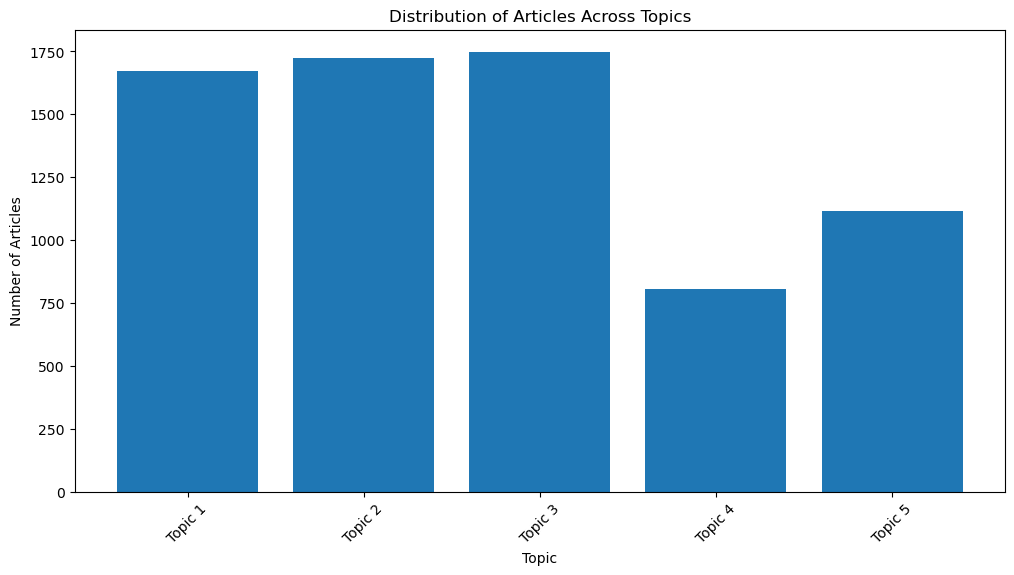

In [22]:

# get document-topic distribution
doc_topic_dist = lda_model_five.transform(bow_matrix)

# counts how many documents have their highest probability in each topic
topic_counts = np.argmax(doc_topic_dist, axis=1)
topic_counts = np.bincount(topic_counts, minlength=lda_model_five.n_components)

# Step 3: Visualize the Distribution
plt.figure(figsize=(12, 6))
plt.bar(range(lda_model_five.n_components), topic_counts, tick_label=['Topic {}'.format(i+1) for i in range(lda_model_five.n_components)])
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles Across Topics')
plt.xticks(rotation=45)
plt.show()

### 2 topic model

In [23]:
lda_model_two = LatentDirichletAllocation(n_components=2, 
                                      max_iter=50,
                                      random_state=42)

In [24]:
lda_model_two.fit(bow_matrix)

LatentDirichletAllocation(max_iter=50, n_components=2, random_state=42)

In [26]:
num_top_words = 50

topic_two = []
for topic_idx, topic in enumerate(lda_model_two.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(", ".join(top_words))
    topic_two.append(top_words)

Topic 1:
united, states, government, say, trump, president, politic, new, state, election, party, year, police, federal, people, department, washington, donald, international, official, force, house, health, law, war, court, day, american, coronavirus, obama, right, military, defense, week, republican, make, china, company, country, plan, murder, world, news, tuesday, leader, group, presidential, care, job, ukraine
Topic 2:
new, york, city, year, book, time, make, university, day, ny, life, game, college, wedding, like, marry, movie, world, home, team, television, engagement, say, good, play, work, school, saturday, art, tv, season, week, open, come, die, manhattan, national, puzzle, football, night, park, long, woman, program, music, know, run, look, basketball, couple


In [27]:
id2word = {i: token for i, token in enumerate(feature_names)}

num_top_words = 50
topic_two = []
for topic_idx, topic in enumerate(lda_model_two.components_):
    top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
    topic_words2 = [feature_names[i] for i in top_features_ind]
    topic_two.append(topic_words2)
    

# compute Coherence Score 
coherence_model_lda = CoherenceModel(topics=topic_two, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score (C_v): ', coherence_lda)

Coherence Score (C_v):  0.41654486678578173


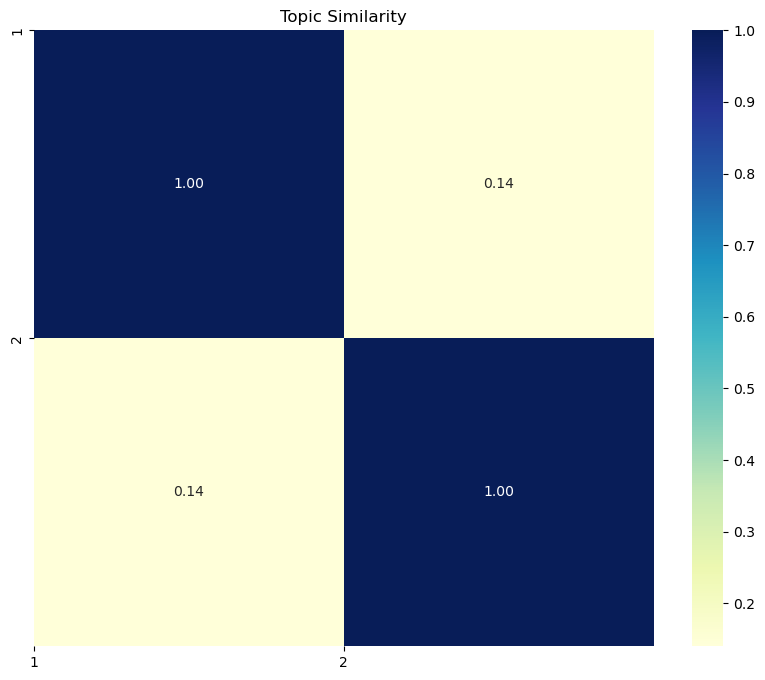

In [28]:
#create similarity heatmap
bow = vectorizer.transform([' '.join(words) for words in topic_two])

similarity_matrix = []

for topic_1 in bow:
    for topic_2 in bow:
        similarity_matrix.append(cosine_similarity(topic_1, topic_2)[0][0])

similarity_matrix = np.matrix(similarity_matrix).reshape(2, 2)

plt.figure(figsize=(10, 8))
# plt.imshow(, cmap='YlGnBu', interpolation='nearest')
sns.heatmap(similarity_matrix.reshape((2, 2)), annot=True, cmap="YlGnBu", fmt=".2f")

plt.xticks(np.arange(2), np.arange(1, 3))
plt.yticks(np.arange(2), np.arange(1, 3))

plt.title("Topic Similarity")
plt.show()

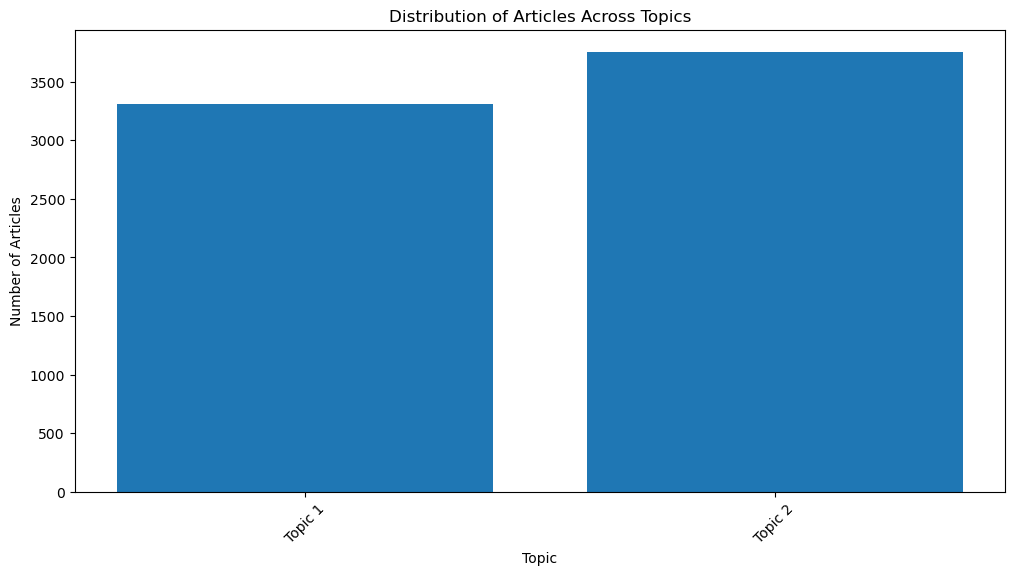

In [39]:

# get document-topic distribution
doc_topic_dist = lda_model_two.transform(bow_matrix)

# counts how many documents have their highest probability in each topic
topic_counts = np.argmax(doc_topic_dist, axis=1)
topic_counts = np.bincount(topic_counts, minlength=lda_model_two.n_components)

# Step 3: Visualize the Distribution
plt.figure(figsize=(12, 6))
plt.bar(range(lda_model_two.n_components), topic_counts, tick_label=['Topic {}'.format(i+1) for i in range(lda_model_two.n_components)])
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles Across Topics')
plt.xticks(rotation=45)
plt.show()

# Save the pickle for future use (i.e. for a new notebook to use classification)

In [29]:


with open('out/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)